# Building Demand Method 1 Simplified

#### Brief overview:

The energy demand for each cell is assessed according to the following parameters:
𝐵 Number of buildings
𝑆𝑟𝑒𝑠 Share of res buildings
𝑁 Nb of HH per res buildings
𝑎 Electrified status (probability)
𝐸_𝐻𝐻  Energy consumption per HH
𝑟 Adjustment with RWI

For each cell c, we have 𝐷_𝑐=𝐵_𝑐∗𝑆𝑟𝑒𝑠∗𝑁_𝑐  ∗𝑎_𝑐  ∗𝐸_𝐻𝐻  ∗𝑟_𝑐 

### Import necessary modules

In [1]:
# Check if we are running the notebook directly, if so move workspace to parent dir
import sys
import os
currentdir = os.path.abspath(os.getcwd())
if os.path.basename(currentdir) != 'DemandMappingZambia':  
  sys.path.insert(0, os.path.dirname(currentdir))
  os.chdir('..')
  print(f'Move to {os.getcwd()}')

Move to C:\Users\amillot\PycharmProjects\DemandMappingZambia


In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.geometry.polygon import Polygon
from shapely.geometry import shape, mapping
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from shapely.ops import unary_union
from pyproj import CRS
from osgeo import ogr, gdal, osr
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
import json
import fiona
import h3 as h3

# Mapping / Plotting
from functools import reduce
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import LogNorm
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors
%matplotlib inline

In [3]:
import tkinter as tk
from tkinter import filedialog, messagebox
import datetime
import warnings
import scipy.spatial
warnings.filterwarnings('ignore')

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.2f}'.format

In [4]:
from utils import processing_raster, finalizing_rasters

### Define directories and projection system

In [5]:
### Define directories and dataset names
ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs"

In [6]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

### Define area of interest

In [7]:
try: area
except NameError: area = "COUNTRY"
# area = "Copperbelt"

In [8]:
## Regions list
regions_path = "admin/"
regions_list = 'Regions_list.csv'
df_regions = pd.read_csv(regions_path + regions_list)
regions = df_regions['Regions GADM']
if area != "COUNTRY":
    regions = [area]
regions

0       Copperbelt
1         Muchinga
2    North-Western
3          Western
4          Luapula
5         Northern
6          Central
7         Southern
8          Eastern
9           Lusaka
Name: Regions GADM, dtype: object

## Import GIS data

### Import layers to be used

In [9]:
hexagons = gpd.read_file(out_path + "\\" + "h3_grid_at_hex.shp")

In [10]:
grid = hexagons

In [11]:
grid.head(4)

,h3_index,n0,n1,n2,n3,n4,n5,index,index_righ,NAME_1,id,geometry
0,8796ac719ffffff,111238,92976,57699,17950,39034,30112,0,7,Northern,1,"POLYGON ((31.60827 -8.91769, 31.59585 -8.92406..."
1,879666d01ffffff,84135,30262,23339,78779,27081,87581,1,9,Western,2,"POLYGON ((22.6268 -16.18863, 22.61389 -16.1945..."
2,879614544ffffff,51580,116954,62120,62784,20898,27553,2,2,Eastern,3,"POLYGON ((32.37868 -12.23976, 32.36612 -12.246..."
3,879670029ffffff,55555,56171,108094,99074,96523,23735,3,6,North-Western,4,"POLYGON ((23.44541 -13.96184, 23.4326 -13.9678..."


### Extract raster values to hexagons

Extract count of buildings per hex from WorldPop

In [12]:
pathWorldPopBuiCount = "Residential/Data/WorldPop/ZMB_buildings_v2_0_count.tif"
# grid = processing_raster("buildings", "count", grid, filepath=pathWorldPopBuiCount)
grid = processing_raster("buildings", "sum", grid, filepath=pathWorldPopBuiCount) #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/
# pathWorldPopBuiArea = "Residential/Data/WorldPop/Copperbelt_buildings_v2_0_total_area.tif"
# grid = processing_raster("bui_area_WP", "sum", grid, filepath=pathWorldPopBuiArea) #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/

2024-12-03 16:02:07.997157


Extract urban areas from WorldPop

In [13]:
pathWorldPopBuiUrban = "Residential/Data/WorldPop/ZMB_buildings_v2_0_urban.tif"
grid = processing_raster("locationWP", "median", grid, filepath=pathWorldPopBuiUrban)      #Copperbelt_population_v1_0_gridded from https://apps.worldpop.org/peanutButter/

2024-12-03 16:09:54.724266


Extract lighing data

In [14]:
## set_lightscore_sy_xxxx.tif: Predicted likelihood that a settlement is electrified (0 to 1)
## http://www-personal.umich.edu/~brianmin/HREA/data.html
# pathHREA = "Residential/Data/Lighting/Copperbelt_set_lightscore_sy_2019_Nodata_values_fixed.tif"
pathHREA = "Residential/Data/Lighting/Zambia_set_lightscore_sy_2019.tif"
grid = processing_raster("HREA", "mean", grid, filepath=pathHREA)
probElec= "HREA"

2024-12-03 18:43:27.308483


Extract RWI

In [15]:
# Relative Wealth Index (RWI) -- extracting the mean value per building
# Link: https://gee-community-catalog.org/projects/rwi/
pathRWI = "Residential/Data/WealthIndex/rwi_map.tif"
grid = processing_raster("rwi", "mean", grid, filepath=pathRWI)

2024-12-04 01:42:11.046391


Extract tiers Falchetta dataset

In [16]:
# extract tiers share from Falchetta dataset #https://www.nature.com/articles/s41597-019-0122-6#Sec7
pathElecAccess = "Residential/Data/Falchetta_ElecAccess/Zambia_tiersofaccess_2018.tif"
grid = processing_raster("tiers_falchetta", "majority", grid, filepath=pathElecAccess)

2024-12-04 11:43:50.762622


In [17]:
# extract tiers share from Falchetta dataset #https://www.nature.com/articles/s41597-019-0122-6#Sec7
pathElecAccess = "Residential/Data/Falchetta_ElecAccess/Zambia_tiersofaccess_2018.tif"
grid = processing_raster("tiers_falchetta", "mean", grid, filepath=pathElecAccess)

2024-12-04 11:52:10.348376


Extract GDP Kummu dataset 

In [18]:
#Link https://www.nature.com/articles/sdata20184#Sec9
pathGDP = "Residential/Data/GDP/GDP_PPP_30arcsec_v3_band3_Zambia.tif"
grid = processing_raster("GDP_PPP", "mean", grid, filepath=pathGDP)

2024-12-04 11:59:45.157389


##### Once done with rasters run this cell

In [19]:
grid = finalizing_rasters(out_path, grid, crs_proj)

2024-12-04 12:00:01.909573


In [20]:
grid.rename({'HREAmean': 'HREA'}, axis=1, inplace=True)
grid.rename({'rwimean': 'rwi'}, axis=1, inplace=True)
grid.rename({'locationWPmedian': 'locationWP'}, axis=1, inplace=True)
grid.rename({'tiers_falchettamajority': 'tiers_falchetta_maj'}, axis=1, inplace=True)
grid.rename({'tiers_falchettamean': 'tiers_falchetta_mean'}, axis=1, inplace=True)
grid['tiers_falchetta_mean'] = grid['tiers_falchetta_mean'].round().astype(int)
grid.rename({'GDP_PPPmean': 'GDP_PPP'}, axis=1, inplace=True)

Add 0 values in HREA column when there is none

In [21]:
grid['HREA'] = grid['HREA'].fillna(0)

Add values in RWI column when there is none

In [22]:
grid["rwi"].fillna(grid["rwi"].mean(numeric_only=True).round(1), inplace=True)
print(grid["rwi"].min())
print(grid["rwi"].max())

-1.430999994277954
1.4987499713897705


In [23]:
grid.head(3)

,h3_index,n0,n1,n2,n3,n4,n5,index,index_righ,NAME_1,id,buildingssum,locationWP,HREA,rwi,tiers_falchetta_maj,tiers_falchetta_mean,GDP_PPP,geometry
0,8796ac719ffffff,111238,92976,57699,17950,39034,30112,0,7,Northern,1,258.00,0.00,0.07,-0.32,0.00,0,NaN,"POLYGON ((31.60827 -8.91769, 31.59585 -8.92406..."
1,879666d01ffffff,84135,30262,23339,78779,27081,87581,1,9,Western,2,NaN,NaN,0.00,-0.40,0.00,0,NaN,"POLYGON ((22.6268 -16.18863, 22.61389 -16.1945..."
2,879614544ffffff,51580,116954,62120,62784,20898,27553,2,2,Eastern,3,NaN,NaN,0.00,-0.40,0.00,0,NaN,"POLYGON ((32.37868 -12.23976, 32.36612 -12.246..."


### Extract residential and service demand from UN stats

In [24]:
# Residential energy demand at the country level
energyBalance_path = "EnergyBalance/"
file_energyBalance = "UNSD+DF_UNData_EnergyBalance+1.0_Zambia.csv"
eb = pd.read_csv(energyBalance_path + file_energyBalance)
code_elec = "B07_EL"
code_hh =  "B50_1231"
total_residentialenergy_TJ = eb.loc[(eb['COMMODITY'] == code_elec) & (eb['TRANSACTION'] == code_hh) & (eb['TIME_PERIOD'] == 2019 ), 'OBS_VALUE'] #TJ
total_residentialenergy_TJ = pd.to_numeric(total_residentialenergy_TJ.str.replace(',', '')) # convert to numeric and remove commas
total_residentialenergy_GWh = total_residentialenergy_TJ.iloc[0]/3.6 # conversion in GWh
print("Residential electricity consumption UN stats", total_residentialenergy_GWh, "GWh")

Residential electricity consumption UN stats 4022.5 GWh


In [25]:
code_ser =  "B49_1235"
cod_oth = "B51_1234" # Other consumption not elsewhere specified in UN stats
total_servicesenergy = eb.loc[(eb['COMMODITY'] == code_elec) & (eb['TRANSACTION'] == code_ser) & (eb['TIME_PERIOD'] == 2019 ), 'OBS_VALUE'] #TJ
total_servicesenergy = pd.to_numeric(total_servicesenergy.str.replace(',', '')) # convert to numeric and remove commas
total_servicesenergy_GWh = total_servicesenergy.iloc[0]/3.6 # conversion in GWh
print("services electricity consumption UN STATS:", f"{total_servicesenergy_GWh:,.0f}", "GWh")

services electricity consumption UN STATS: 722 GWh


## Residential electricity consumption assessment

### Step 1: assess the number of HH with access

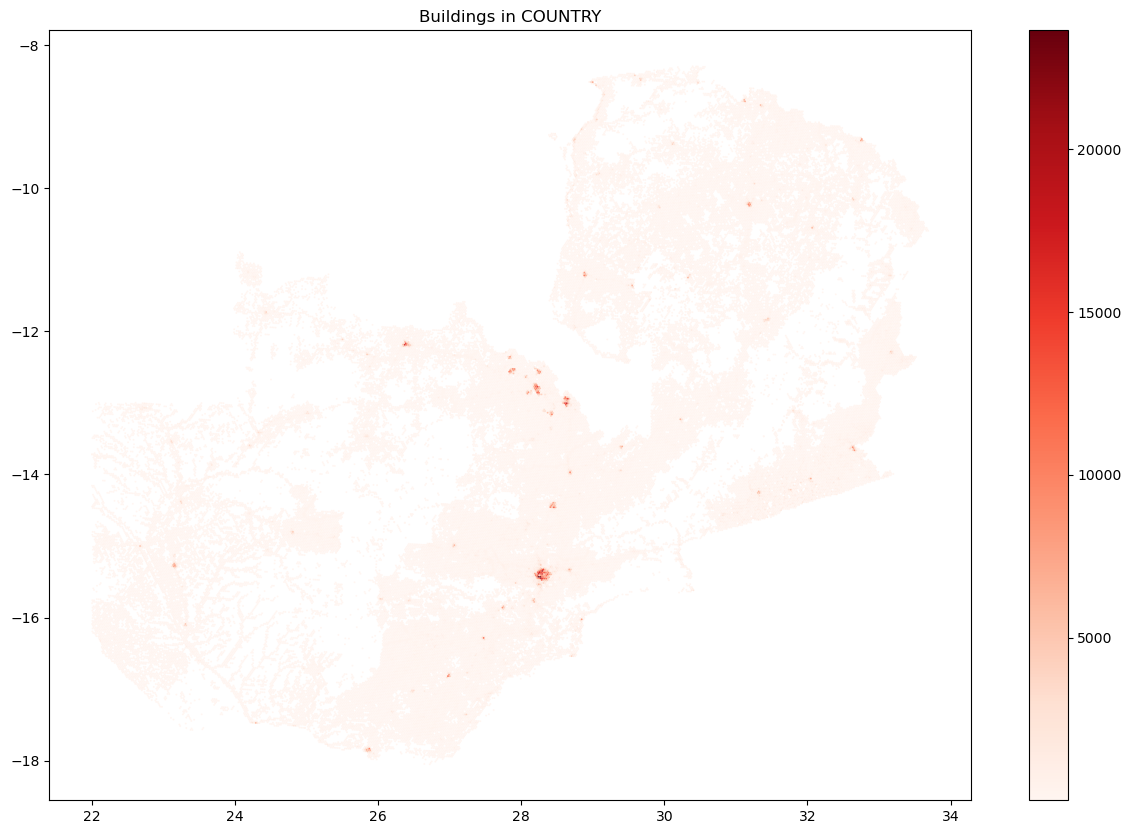

In [88]:
# Plot the buildings map
fig, ax = plt.subplots(figsize=(15, 10))
grid.sort_values('buildingssum', ascending=True).plot(
    ax=ax, column='buildingssum', cmap="Reds", legend=True, alpha=0.9)
ax.set_aspect('equal', 'box')
txt = ax.set_title('Buildings in {}'.format(area) )

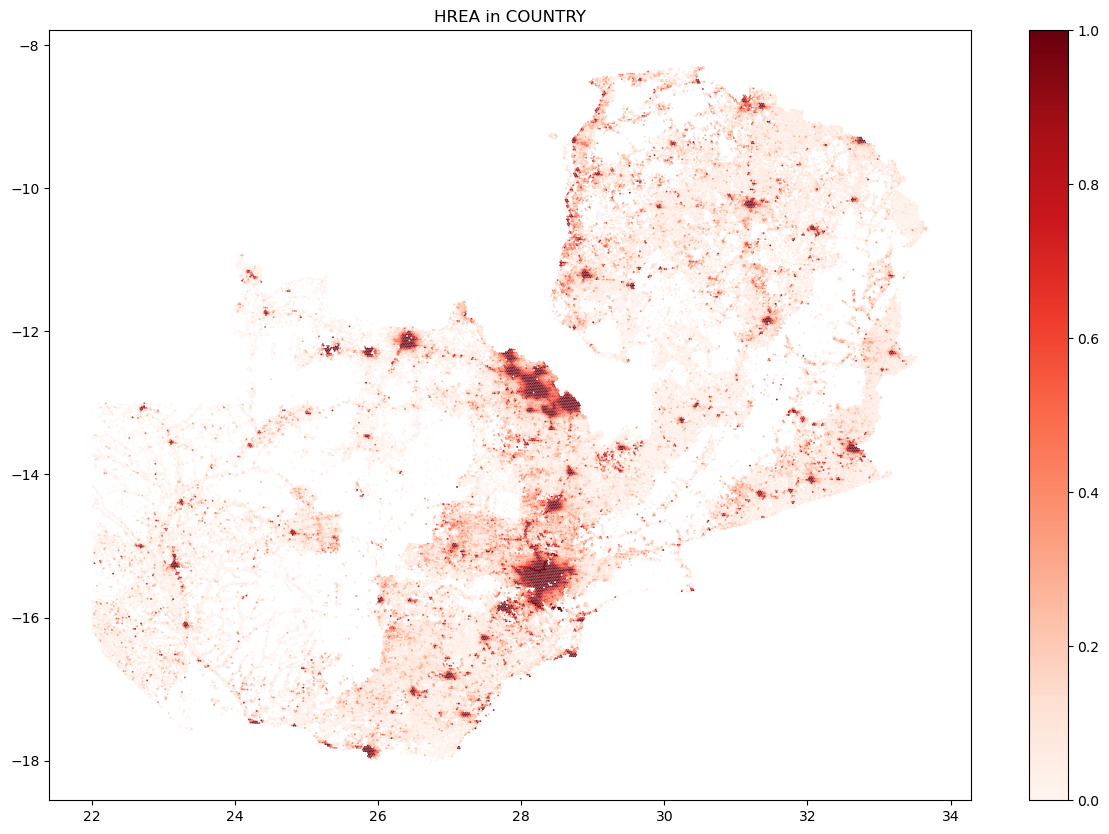

In [89]:
# Plot the lighting map
# Create the axis first
fig, ax = plt.subplots(figsize=(15, 10))

# Filter the data
grid_filtered = grid[(grid['buildingssum'] >= 1000) & (grid['HREA'] <= 0.1)]
grid_filtered = grid[(grid['buildingssum'] >= 2)]
# Plot data
grid_filtered.sort_values('HREA', ascending=True).plot(
    ax=ax, column='HREA', cmap="Reds", legend=True, alpha=0.9)
# # Plot data
# grid.sort_values('buildingssum', ascending=True).plot(
#     ax=ax, column='buildingssum', cmap="Blues", legend=True, alpha=0.9)

ax.set_aspect('equal', 'box')
txt = ax.set_title('HREA in {}'.format(area) )

Determine location (ruban or rural) of each cell

In [90]:
# for each hexagon, determine if it's rural or urban --> choose best source
# grid["locAssessed"] = grid.apply(lambda row: ("urban" if ((row['buildingssum'] > 1000)) # number chosen to get 1 for nb of HH per rural building
#                                              else "rural"), axis=1)
grid["locWorldPop"] = grid.apply(lambda row: ("urban" if ((row['locationWP'] == 1)) 
                                             else "rural"), axis=1)
# grid["locGHSL"] = grid.apply (lambda row: ("urban" if ((row['SMOD'] == 30) or (row['SMOD'] == 21) or (row['SMOD'] == 22) or (row['SMOD' ] == 23)) 
#                                              else "rural"), axis=1)
grid["location"] = grid["locWorldPop"] 

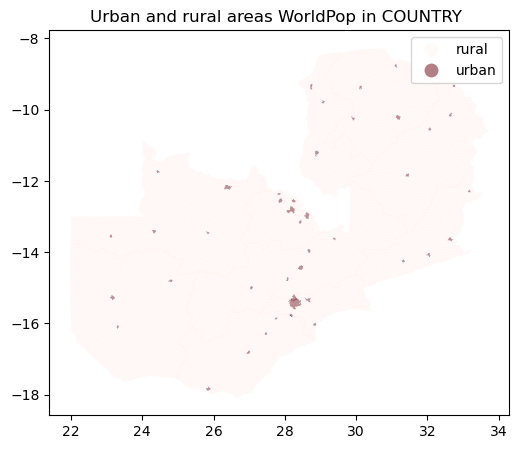

In [91]:
# map of the urban and rural areas WorldPop
fig2, ax2 = plt.subplots(figsize=(10, 5))
grid.sort_values('locWorldPop', ascending=True).plot(
    ax=ax2, column='locWorldPop', cmap="Reds", legend=True, alpha=0.5)
ax2.set_aspect('equal', 'box')
txt = ax2.set_title('Urban and rural areas WorldPop in {} '.format(area))

Determine electrifed status of each cell

In [92]:
# electrified or non-electrified status with thresholds depending on the location
threshold_elec_access = {'urban': 0.9, 'rural': 0.1}
grid["Status_electrified"] = grid.apply(
    lambda row: "elec" if row[probElec] > threshold_elec_access[row['location']] else "nonelec",
    axis=1
)

print(grid["Status_electrified"].value_counts())

Status_electrified
nonelec    88165
elec       36417
Name: count, dtype: int64


#### Province data available

In [93]:
province_data = True

In [94]:
if province_data == True:
    # Census data: adjust to the country
    data_path = "Residential/Data/"
    census_name = 'Census_Zambia.csv'
    df_censusdata = pd.read_csv(data_path + census_name)
    
    # Create a new dataframe that will contain the regional data
    data_HH = df_censusdata[['Region', 'Urban', 'Rural']]
    data_HH = data_HH.rename({'Region':'region','Urban':'HH_urban', 'Rural':'HH_rural'}, axis = 1)
    data_HH = data_HH.set_index(['region'])
    data_HH['HH_total'] = data_HH['HH_urban'] + data_HH['HH_rural']
    data_HH = data_HH.astype(float)

In [95]:
if province_data == True:
    # Option 1: use buildings count from Worldpop to assess number of buildings
    # total number of buildings
    data_buildings = []
    for region in regions:
        totalBuildings = grid[(grid['NAME_1'] == region)]['buildingssum'].sum()
        urbanBuildings = grid[(grid['location'] == "urban") & (grid['NAME_1'] == region)]['buildingssum'].sum()
        ruralBuildings = grid[(grid['location'] == "rural") & (grid['NAME_1'] == region)]['buildingssum'].sum()
        data_region = {
            'region': region,
            'totalBuildings': totalBuildings,
            'urbanBuildings': urbanBuildings,
            'ruralBuildings': ruralBuildings,
            'shareRuralBuild': ruralBuildings / totalBuildings,
            'shareUrbanBuild': urbanBuildings / totalBuildings,
        }
        data_buildings.append(data_region)
        # print("total Buildings in",f"{region}",f"{totalBuildings:,.0f}", "urban:",f"{urbanBuildings:,.0f}", "rural:",f"{ruralBuildings:,.0f}")
        # print("share Build urban:", f"{data_region['shareUrbanBuild']:.0%}","rural:",f"{data_region['shareRuralBuild']:.0%}")
    
    df_buildings = pd.DataFrame(data_buildings)
    df_buildings = df_buildings.set_index('region')
    # df_buildings
    df_HH_buildings = data_HH.merge(df_buildings, left_on='region', right_on='region')
    df_HH_buildings

Assess number of residential buildings

In [96]:
if province_data == True:
    # share of residential building in each location --> not used because we use the assumption of nb of HH per res bui but can be used if we have data on share of residential building
    # shareResBuildings = {"urban": 0.5, "rural": 0.15} # --> to change! # number chosen to get 1 for nb of HH per rural building, and for urban twice the value in rural
    # df_HH_buildings['resUrbanBui'] = df_HH_buildings['urbanBuildings'] * shareResBuildings["urban"]
    # df_HH_buildings['resRuralBui'] = df_HH_buildings['ruralBuildings'] * shareResBuildings["rural"]
    # df_HH_buildings['resTotalBui'] = df_HH_buildings['resUrbanBui'] + df_HH_buildings['resRuralBui']
    
    # Assess the number of residential HH per building
    nbOfHHperResBuilding =  {"urban": 1.1, "rural": 1}  # --> to update depending on the country
    # nbOfHHperResBuilding["urban"]= HH_urban/resUrbanBuildings --> use if the main assumption is on the share of res buildings
    # nbOfHHperResBuilding["rural"]= HH_rural/resRuralBuildings --> use if the main assumption is on the share of res buildings
    
    # Assess the number of residential buildings
    df_HH_buildings['shareUrbanResBui'] = df_HH_buildings['HH_urban'] /(nbOfHHperResBuilding["urban"]* df_HH_buildings['urbanBuildings'])
    df_HH_buildings['shareRuralResBui'] = df_HH_buildings['HH_rural'] /(nbOfHHperResBuilding["rural"]* df_HH_buildings['ruralBuildings'])
    df_HH_buildings['resUrbanBui'] = df_HH_buildings['urbanBuildings'] * df_HH_buildings['shareUrbanResBui']
    df_HH_buildings['resRuralBui'] = df_HH_buildings['ruralBuildings'] * df_HH_buildings['shareRuralResBui']
    df_HH_buildings['resTotalBui'] = df_HH_buildings['resUrbanBui'] + df_HH_buildings['resRuralBui']
    
    # Check: Assess the total number of HH in the region (should match the census data)
    totalResHHurban = nbOfHHperResBuilding["urban"]*df_HH_buildings['resUrbanBui']
    # assert totalResHHurban.equals(df_HH_buildings['HH_urban'])
    totalResHHrural = nbOfHHperResBuilding["rural"]*df_HH_buildings['resRuralBui']
    # assert totalResHHrural.equals(df_HH_buildings['HH_rural'])
    
    # Number of HH per res buildings in each region average
    df_HH_buildings['nbOfHHperResBui_average'] = df_HH_buildings['HH_total'] / (df_HH_buildings['urbanBuildings']*df_HH_buildings['shareUrbanResBui'] +
                                                                     df_HH_buildings['ruralBuildings'] * df_HH_buildings['shareRuralResBui'])
    
    # df_HH_buildings

In [97]:
if province_data == True:
    # Assess the number of residential building
    grid['res_urbanBui'] = grid['buildingssum'] * (grid['location'] == 'urban') * grid['NAME_1'].map(df_HH_buildings['shareUrbanResBui'])
    grid['res_ruralBui'] = grid['buildingssum'] * (grid['location'] == 'rural') * grid['NAME_1'].map(df_HH_buildings['shareRuralResBui'])

#### National data available only

In [98]:
if province_data == False:
    # Census data: adjust to the country
    data_path = "Residential/Data/"
    nationaldata_name = 'Census_Zambia_national.csv' # update name of file
    df_nationaldata = pd.read_csv(data_path + nationaldata_name)
    
    # Create a new dataframe that will contain the regional data
    data_nat_HH = df_nationaldata[['Urban', 'Rural']]
    
    # Assess total buildings
    totalBuildings = grid['buildingssum'].sum()
    urbanBuildings = grid[(grid['location'] == "urban")]['buildingssum'].sum()
    ruralBuildings = grid[(grid['location'] == "rural")]['buildingssum'].sum()

    # Assess the number of residential building
    nbOfHHperResBuilding =  {"urban": 1.1, "rural": 1}  # --> to update depending on the country
    shareResBui_urban = data_nat_HH ['Urban']/nbOfHHperResBuilding['urban']/urbanBuildings
    shareResBui_rural = data_nat_HH ['Rural']/nbOfHHperResBuilding['rural']/ruralBuildings
    grid['res_urbanBui'] = grid['buildingssum'] * (grid['location'] == 'urban') * shareResBui_urban
    grid['res_ruralBui'] = grid['buildingssum'] * (grid['location'] == 'rural') * shareResBui_rural

#### Assess number of residential households per cell

In [99]:
# Assess the number of HH per cell
grid['res_Bui'] = grid['res_urbanBui'] + grid['res_ruralBui']
grid['HH_urban'] = grid['res_urbanBui'] * nbOfHHperResBuilding['urban']
grid['HH_urban'] = grid['HH_urban'].fillna(0)
grid['HH_rural'] = grid['res_ruralBui'] * nbOfHHperResBuilding['rural']
grid['HH_rural'] = grid['HH_rural'].fillna(0)
grid['HH_total'] = grid['HH_rural'] + grid['HH_urban']

In [100]:
if province_data == True:
    # Population per cell
    df_censusdata = df_censusdata.set_index('Region')
    # df_censusdata
    # in each cell compute the population size = HH * HH size
    get_size_HH = lambda row: df_censusdata.loc[row['NAME_1'], 'size_HH_' + row['location']]
    grid['population'] = (
        grid['HH_total'] *
        grid.apply(get_size_HH, axis=1)
        )
    total_population = grid['population'].sum()
    print(f"Total population: {total_population:,.0f}")
    grid['population_urban'] = (
        grid['HH_urban'] *
        grid.apply(get_size_HH, axis=1)
        )
    grid['population_rural'] = (
        grid['HH_rural'] *
        grid.apply(get_size_HH, axis=1)
        )
    grid['population2'] = grid['population_rural'] + grid['population_urban']
    total_population2 = grid['population2'].sum()
    print(f"Total population: {total_population2:,.0f}")

Total population: 17,798,700
Total population: 17,798,700


Assess number of residential households per cell with access to electricity

In [101]:
# for each hexagon, assessment of the number of HH with access
correction_factor_urban = 0.85
grid["HHwithAccess_urb"] = grid['HH_urban'] * grid[probElec] * (grid["Status_electrified"]=='elec') * correction_factor_urban
grid["HHwithAccess_rur"] = grid['HH_rural'] * grid[probElec] * (grid["Status_electrified"]=='elec')
# nan_count = grid['HHwithAccess_rur'].isna().sum()
# print(nan_count)
grid["HHwithAccess"] = grid["HHwithAccess_urb"] + grid["HHwithAccess_rur"]

grid["HHwithAccess_urb_wostatus"] = grid['HH_urban'] * grid[probElec]
grid["HHwithAccess_rur_wostatus"] = grid['HH_rural'] * grid[probElec]                                  
grid["HHwithAccess_wostatus"] = grid["HHwithAccess_urb_wostatus"] + grid["HHwithAccess_rur_wostatus"]

grid['HHwoAccess_urb'] = grid['HH_urban'] - grid['HHwithAccess_urb']
grid['HHwoAccess_rur'] = grid['HH_rural'] - grid['HHwithAccess_rur']
grid['HHwoAccess'] = grid['HHwoAccess_urb'] + grid['HHwoAccess_rur']

# print(grid['HHwoAccess_rur'].sum(), grid['HHwithAccess_rur'].sum(), grid['HHwoAccess_rur'].sum()+ grid['HHwithAccess_rur'].sum(), grid['HH_rural'].sum())
# print(grid['HHwoAccess_rur'].dtype, grid['HHwithAccess_rur'].dtype, grid['HH_rural'].dtype)

if province_data == True:
    totalHHWithAccessUrb = grid.groupby('NAME_1')['HHwithAccess_urb'].sum()
    totalHHWithAccessRur = grid.groupby('NAME_1')['HHwithAccess_rur'].sum()
    totalHHWithAccess = grid.groupby('NAME_1')['HHwithAccess'].sum()
    
    totalHHWithAccessUrb_wostatus = grid.groupby('NAME_1')['HHwithAccess_urb_wostatus'].sum()
    totalHHWithAccessRur_wostatus = grid.groupby('NAME_1')['HHwithAccess_rur_wostatus'].sum()
    totalHHWithAccess_wostatus = grid.groupby('NAME_1')['HHwithAccess_wostatus'].sum()
    
    df_HH_access = pd.concat([totalHHWithAccessUrb, totalHHWithAccessRur, totalHHWithAccess,totalHHWithAccessUrb_wostatus,totalHHWithAccessRur_wostatus,totalHHWithAccess_wostatus], axis=1)
    df_HH_access.rename_axis('region', inplace=True)
    df_HH_buildings = df_HH_buildings.merge(df_HH_access, left_on='region', right_on='region')
    df_HH_buildings


In [102]:
if province_data == True:
    # Add national results
    df_sum = df_HH_buildings.sum(axis=0)  # Sum across rows
    df_sum.name = 'National'  # Set a name for the new row
    df_HH_buildings = pd.concat([df_HH_buildings, df_sum.to_frame().T]) # concatenate the sum Series as a new row
    df_HH_buildings

In [103]:
if province_data == True:
    # in each cell compute the population with access size
    grid['population_urban_withAccess'] = (
        grid['HHwithAccess_urb'] *
        grid.apply(get_size_HH, axis=1)
        )
    grid['population_rural_withAccess'] = (
        grid['HHwithAccess_rur'] *
        grid.apply(get_size_HH, axis=1)
        )
    grid['population_withAccess'] = grid['population_urban_withAccess'] + grid['population_rural_withAccess']
    total_population_withAccess = grid['population_withAccess'].sum()
    print(f"Total population with access: {total_population_withAccess:,.0f}")

Total population with access: 8,239,939


Compute the resulting access rate

In [104]:
if province_data == True:
    # Access rate for HH
    df_HH_buildings['accessRateHH'] = df_HH_buildings['HHwithAccess']/df_HH_buildings['HH_total']
    df_HH_buildings['accessRateHH_urban'] = df_HH_buildings['HHwithAccess_urb']/df_HH_buildings['HH_urban']
    df_HH_buildings['accessRateHH_rural'] = df_HH_buildings['HHwithAccess_rur']/df_HH_buildings['HH_rural']
    
    # access rate for population
    accessRatePop_urban = grid['population_urban_withAccess'].sum()/grid['population_urban'].sum()
    accessRatePop_rural = grid['population_rural_withAccess'].sum()/grid['population_rural'].sum()
    accessRatePop = grid['population_withAccess'].sum()/grid['population'].sum()
    print("Pop access rate :",f"{accessRatePop:,.0%}")
    print("Pop access rate urban:",f"{accessRatePop_urban:,.0%}")
    print("Pop access rate rural:",f"{accessRatePop_rural:,.0%}")
    
    df_HH_buildings.to_csv('Residential/Outputs/'+"dataHH_region.csv")
    df_HH_buildings[['accessRateHH','accessRateHH_urban','accessRateHH_rural']]

Pop access rate : 46%
Pop access rate urban: 82%
Pop access rate rural: 23%


### Step 2: assess the energy consumption per HH

#### Method 1: link the energy consumption to rwi through a logistic function

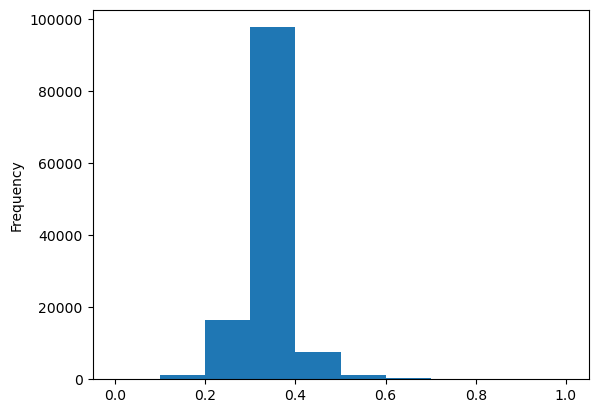

In [105]:
# Normalise the rwi index
rwi_min = grid['rwi'].min()
rwi_max = grid['rwi'].max()
grid['rwi_norm'] = (grid['rwi'] - rwi_min) / (rwi_max - rwi_min)
grid['rwi_norm'].plot.hist()
plt.show()

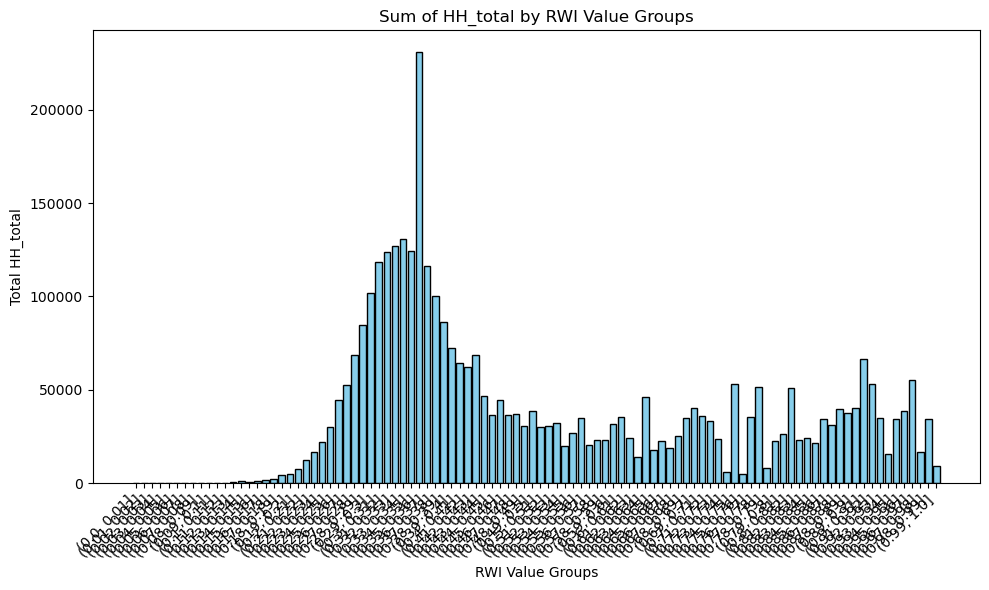

In [106]:
# Plot of number of HH vs rwi

# Create equally spaced bins for the 'rwi' values
num_groups = 100
min_rwi = grid['rwi_norm'].min()
max_rwi = grid['rwi_norm'].max()
bin_width = (max_rwi - min_rwi) / num_groups
rwi_bins = [min_rwi + i * bin_width for i in range(num_groups + 1)]
rwi_bins_labels = [(rwi_bins[i] + rwi_bins[i])/2 for i in range(num_groups)]

# Group by the bins and sum the 'HH_total' values
grid['rwi_group'] = pd.cut(grid['rwi_norm'], rwi_bins)
result = grid.groupby('rwi_group')['HH_total'].sum()
result.index = result.index.astype(str)
# # Print the result
# print(result)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(result.index, result.values, color='skyblue', edgecolor='black')
# plt.bar(rwi_bins_labels, result.values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('Total HH_total')
plt.title('Sum of HH_total by RWI Value Groups')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

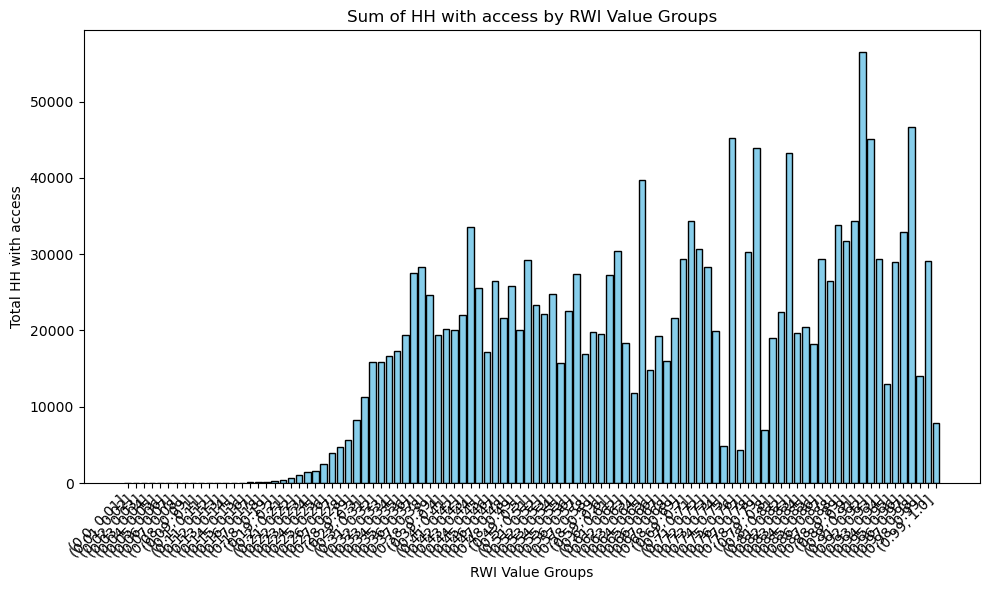

In [107]:
# Plot of number of HH with access vs rwi

# Group by the bins and sum the 'HHwithAccess' values
result = grid.groupby('rwi_group')['HHwithAccess'].sum()
result.index = result.index.astype(str)
# # Print the result
# print(result)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(result.index, result.values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('Total HH with access')
plt.title('Sum of HH with access by RWI Value Groups')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [108]:
# solve the equation so that the energy consumption per HH matches total energy demand
from scipy.optimize import fsolve

# variable for the relatioship between rwi and E
E_threshold = 4656 # adjust threshold to country
alpha = E_threshold / 0.1 - 1  # alpha set so that E_HH = 7 kWh for the lowest tier

def func(x):
    e_hh = E_threshold / (1 + alpha * np.exp(-x  * grid['rwi_norm']))
    res_energy_assessed = e_hh * grid ['HHwithAccess']
    return res_energy_assessed.sum()/10**6- total_residentialenergy_GWh

# Use scipy to solve the equation to find k
k_initial_guess = 5
k_solution = fsolve(func, k_initial_guess)
print(k_solution)


[15.8455931]


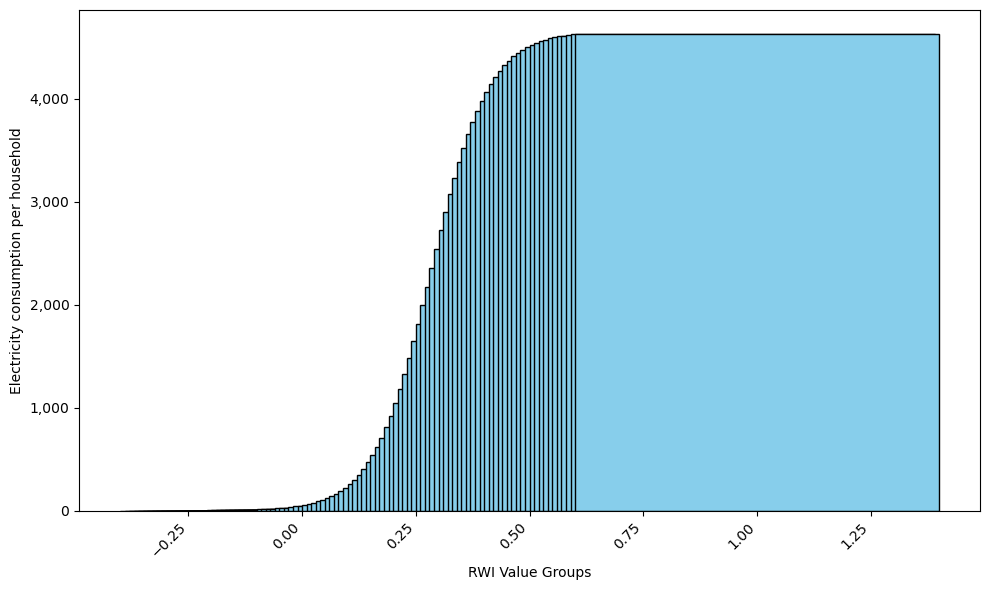

In [109]:
# create the curve linking energy consumption per HH and rwi
rwi_values = rwi_bins # rwi value groups
k = k_solution  # Adjust this constant for the desired curve steepness
E_HH_values = E_threshold / (1 + alpha * np.exp(-k * np.array(rwi_values)))
# print(E_threshold / (1 + alpha * np.exp(-k  * 0)))
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(rwi_values, E_HH_values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('Electricity consumption per household')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
# plt.title('Energy vs. RWI with logistic relationship')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

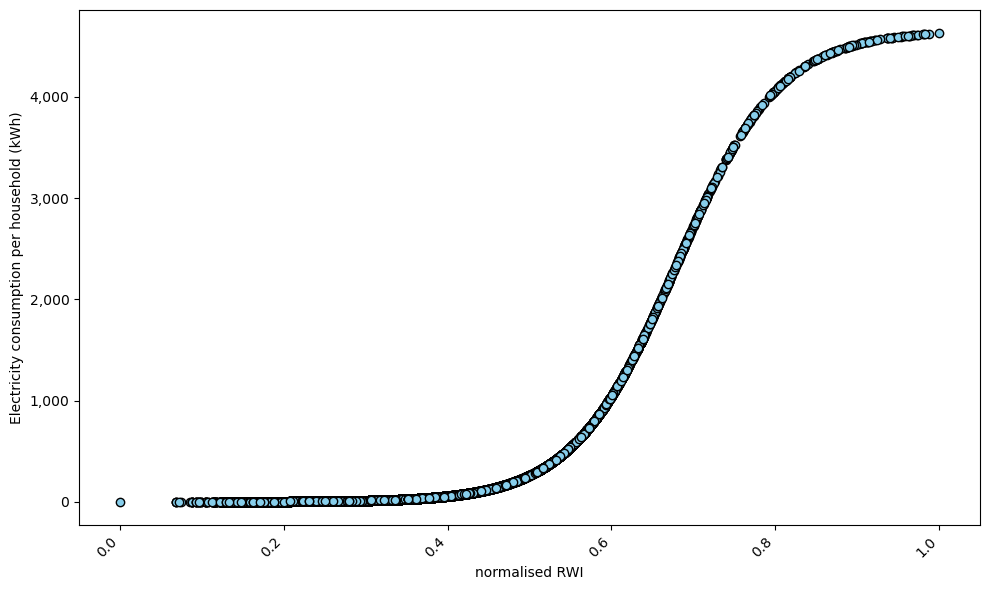

In [110]:
# check that total energy assessed matches the statistics
grid['ResEnergyPerHH_log'] = E_threshold / (1 + alpha * np.exp(-k * grid['rwi_norm']))

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.scatter(grid['rwi_norm'], grid['ResEnergyPerHH_log'], color='skyblue', edgecolor='black')
plt.xlabel('normalised RWI')
plt.ylabel('Electricity consumption per household (kWh)')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
# plt.title('Energy vs. RWI with Logarithmic Relationship')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Method 2: use data coming from the DHS survey

urban total = 2,574 GWh/year
urban average per houshold = 2,004 kWh/year
urban min = 0 kWh/year max = 2,396 kWh/year
Created rwi_vs_energy_use_urban.png


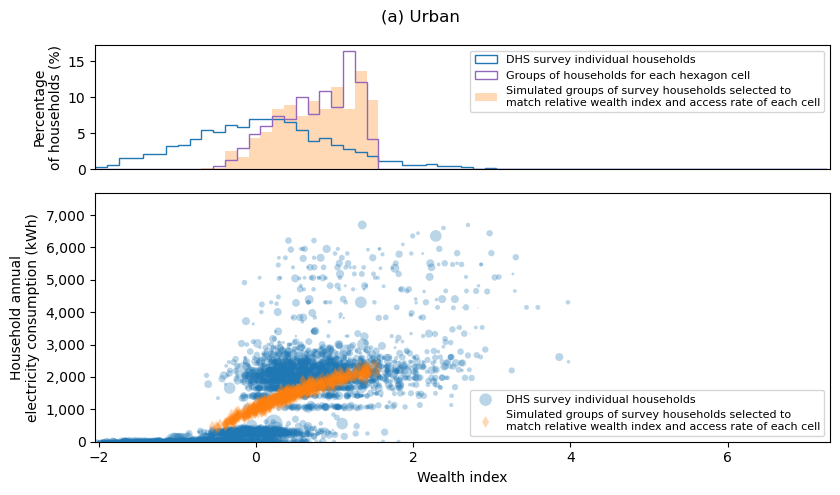

rural total = 38 GWh/year
rural average per houshold = 79 kWh/year
rural min = 0 kWh/year max = 873 kWh/year
Created rwi_vs_energy_use_rural.png


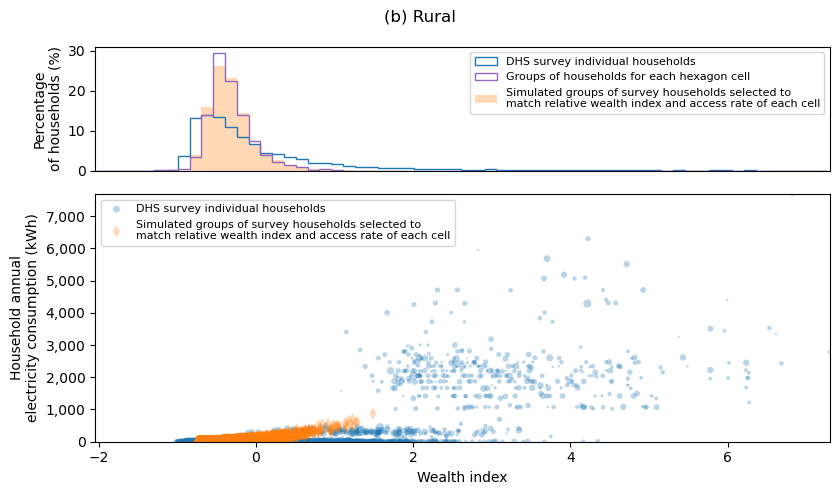

In [111]:
# importlib.reload(estimate_energy_rwi_link_national_new)
from Residential.HouseholdEnergyUse import estimate_energy_rwi_link_national_new
data_path = 'Residential/Data/DHSSurvey/'
figuresDHS_folder = 'Residential/Figures/'
grid = estimate_energy_rwi_link_national_new.estimate_energy_rwi_link_national(grid, data_path, figuresDHS_folder)
grid['ResEnergyPerHH_DHS'] = grid['Energy demand rural'] + grid['Energy demand urban']
grid.to_csv(out_path + "\\" + "data_resDHS.csv")

### Step 3: assess energy consumption per cell

In [112]:
# Assess the energy Consumption assessment per cell
averageRwi = grid['rwi'].mean()
weightedRwi_norm = grid['rwi_norm'] * (grid ['HH_urban'] + grid ['HH_rural'])
averageRwi_norm = weightedRwi_norm.sum()/ (grid ['HH_urban'].sum() + grid ['HH_rural'].sum())
# print(averageRwi_norm)

grid["ResEnergyPerHH_meth1"] = grid.apply(
    lambda row: row['ResEnergyPerHH_log'] if row['HHwithAccess'] > 0 else 0, axis=1
)
grid["ResEnergyPerHH_meth2"] = grid['ResEnergyPerHH_DHS']

In [113]:
methods = ['meth1', 'meth2']
result_beforescaling = pd.DataFrame()
result_afterscaling = pd.DataFrame()
for method in methods:
    grid["ResEnergy_kWh_" + method] = grid["HHwithAccess"] * grid["ResEnergyPerHH_" + method]
    result_beforescaling[method] = grid.groupby('NAME_1')['ResEnergy_kWh_' + method].sum() / 10**6 # conversion in GWh
    total_residentialenergy_assessed = result_beforescaling[method].sum() #res_energy_assessed 
    scaling_factor = total_residentialenergy_GWh/total_residentialenergy_assessed
    result_afterscaling[method] = result_beforescaling[method] * scaling_factor
    grid["ResEnergy_kWh_" + method + "_scaled"] = grid["ResEnergy_kWh_" + method] * scaling_factor
result_beforescaling

# result = pd.DataFrame.from_dict(result_beforescaling)

,meth1,meth2
NAME_1,,
Central,215.26,129.89
Copperbelt,1394.49,690.68
Eastern,101.36,85.91
Luapula,24.33,37.76
Lusaka,1713.53,855.07
Muchinga,19.46,24.97
North-Western,161.04,102.64
Northern,84.50,71.00
Southern,259.90,161.09


In [114]:
result_beforescaling.sum(axis=0)

meth1   4022.50
meth2   2210.22
dtype: float64

In [115]:
result_afterscaling

,meth1,meth2
NAME_1,,
Central,215.26,236.39
Copperbelt,1394.49,1257.00
Eastern,101.36,156.35
Luapula,24.33,68.71
Lusaka,1713.53,1556.19
Muchinga,19.46,45.45
North-Western,161.04,186.81
Northern,84.50,129.22
Southern,259.90,293.18


### Compare access rates to Falchetta dataset

In [116]:
def calculate_tier_share_method(grid, method, HHwithaccess, HHwoaccess, category_total):
    """Calculates tier share for a given category.

    Args:
        grid: The DataFrame containing the data.
        category_prefix: The prefix for the category columns (e.g., 'HHwithAccess').
        category_total: The total number of households in the category.

    Returns:
        A Series containing the tier share for the category.
    """
    
    tier_share = grid.groupby('tiers_' + method)[HHwithaccess].sum()    
    tier_share.iloc[0] += grid[HHwoaccess].sum()
    return tier_share / category_total


# Define the energy consumption level for the different tiers
bins_tiers = [0, 7, 72.9-0.1, 364.9-0.1, 1250.4-0.1, 3012.2-0.1, np.inf]

# Define the different categories
categories = [('national', 'HHwithAccess', 'HHwoAccess', 'HH_total'),
              ('urban', 'HHwithAccess_urb', 'HHwoAccess_urb', 'HH_urban'),
              ('rural', 'HHwithAccess_rur', 'HHwoAccess_rur', 'HH_rural')]

In [117]:
tiers_falchetta_maj = pd.DataFrame()
tiers_falchetta_maj = grid.groupby('tiers_falchetta_maj')[['HH_total', 'HH_urban', 'HH_rural']].sum()
tiers_falchetta_maj = tiers_falchetta_maj / tiers_falchetta_maj.sum()
# for category, HHwithaccess, HHwoaccess, total_col in categories:
#     tier_share = calculate_tier_share_method(grid, 'falchetta', HHwithaccess, HHwoaccess, grid[total_col].sum())
#     tiers_falchetta[category] = tier_share
tiers_falchetta_maj

,HH_total,HH_urban,HH_rural
tiers_falchetta_maj,,,
0.00,0.57,0.06,0.95
1.00,0.00,0.00,0.00
2.00,0.01,0.01,0.01
3.00,0.01,0.01,0.01
4.00,0.41,0.92,0.04


In [118]:
tiers_falchetta_mean = pd.DataFrame()
tiers_falchetta_mean = grid.groupby('tiers_falchetta_mean')[['HH_total', 'HH_urban', 'HH_rural']].sum()
tiers_falchetta_mean = tiers_falchetta_mean / tiers_falchetta_mean.sum()
# for category, HHwithaccess, HHwoaccess, total_col in categories:
#     tier_share = calculate_tier_share_method(grid, 'falchetta', HHwithaccess, HHwoaccess, grid[total_col].sum())
#     tiers_falchetta[category] = tier_share
tiers_falchetta_mean

,HH_total,HH_urban,HH_rural
tiers_falchetta_mean,,,
0,0.51,0.01,0.88
1,0.04,0.02,0.06
2,0.04,0.06,0.03
3,0.06,0.10,0.02
4,0.35,0.80,0.02


In [119]:
tiers_falchetta_withHH = pd.DataFrame()
for category, HHwithaccess, HHwoaccess, total_col in categories:
    tier_share = calculate_tier_share_method(grid, 'falchetta_maj', HHwithaccess, HHwoaccess, grid[total_col].sum())
    tiers_falchetta_withHH[category] = tier_share
tiers_falchetta_withHH

,national,urban,rural
tiers_falchetta_maj,,,
0.00,0.63,0.21,0.95
1.00,0.00,0.00,0.00
2.00,0.01,0.01,0.01
3.00,0.01,0.01,0.01
4.00,0.35,0.78,0.04


In [120]:
# Calculate tier shares for the different methods
df_tiers_data = pd.DataFrame()
for method in methods:
    df_tiers_data = pd.DataFrame()
    grid['tiers_' + method] = pd.cut(grid['ResEnergyPerHH_' + method], bins_tiers, labels=range(len(bins_tiers)-1))
    grid['tiers_' + method] = grid['tiers_' + method].fillna(0) # Fill NaN values with "0"

    for category, HHwithaccess, HHwoaccess, total_col in categories:
        tier_share = calculate_tier_share_method(grid, method, HHwithaccess, HHwoaccess, grid[total_col].sum())
        df_tiers_data[category] = tier_share

    # df_tiers_data = pd.concat([df_tiers_data_national, df_tiers_data_urban, df_tiers_data_rural], axis=1)
    print(df_tiers_data)

             national  urban  rural
tiers_meth1                        
0                0.52   0.18   0.78
1                0.07   0.02   0.11
2                0.07   0.07   0.07
3                0.06   0.11   0.02
4                0.07   0.14   0.01
5                0.21   0.49   0.00
             national  urban  rural
tiers_meth2                        
0                0.54   0.18   0.81
1                0.08   0.00   0.13
2                0.03   0.00   0.05
3                0.05   0.12   0.00
4                0.30   0.70   0.00
5                0.00   0.00   0.00


In [121]:
# comparison between Falchetta and our data
grid['tiers_DHS'] = grid['tiers_meth2']
grid['tiers_DHS_adjusted'] = grid['tiers_DHS'].where(grid['tiers_DHS'] != 5, 4) # adjustment to only have 4 tiers

# Create a new column 'Similarity' to indicate if values are the same
grid['Similarity'] = grid['tiers_DHS_adjusted'] == grid['tiers_falchetta_maj']

# Count the number of lines with similar values
num_similar = grid['Similarity'].sum()

# Calculate the absolute difference between A and B
grid['Difference'] = abs(pd.to_numeric(grid['tiers_DHS_adjusted']) - grid['tiers_falchetta_maj'])

# Analyze the distribution of differences (e.g., mean, median, mode)
mean_difference = grid['Difference'].mean()
median_difference = grid['Difference'].median()
mode_difference = grid['Difference'].mode()

print("Number of lines with similar values:", num_similar)
print("Mean difference:", mean_difference)
print("Median difference:", median_difference)
print("Mode difference:", mode_difference)

Number of lines with similar values: 108419
Mean difference: 0.14285370278210335
Median difference: 0.0
Mode difference: 0   0.00
Name: Difference, dtype: float64


### Final grid

In [122]:
print(grid.columns)
grid.to_csv(out_path + '/data_res.csv')

Index(['h3_index', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'index', 'index_righ',
       'NAME_1', 'id', 'buildingssum', 'locationWP', 'HREA', 'rwi',
       'tiers_falchetta_maj', 'tiers_falchetta_mean', 'GDP_PPP', 'geometry',
       'locWorldPop', 'location', 'Status_electrified', 'res_urbanBui',
       'res_ruralBui', 'res_Bui', 'HH_urban', 'HH_rural', 'HH_total',
       'population', 'population_urban', 'population_rural', 'population2',
       'HHwithAccess_urb', 'HHwithAccess_rur', 'HHwithAccess',
       'HHwithAccess_urb_wostatus', 'HHwithAccess_rur_wostatus',
       'HHwithAccess_wostatus', 'HHwoAccess_urb', 'HHwoAccess_rur',
       'HHwoAccess', 'population_urban_withAccess',
       'population_rural_withAccess', 'population_withAccess', 'rwi_norm',
       'ResEnergyPerHH_log', 'Simulated group rwi urban',
       'Energy demand urban', 'Simulated group rwi rural',
       'Energy demand rural', 'ResEnergyPerHH_DHS', 'ResEnergyPerHH_meth1',
       'ResEnergyPerHH_meth2', 'ResEnergy_k

In [123]:
if 'rwi_group' in grid.columns:
    grid = grid.drop('rwi_group', axis=1)
if 'tiers_DHS' in grid.columns:
    grid = grid.drop('tiers_DHS', axis=1)
if 'bin_labels' in grid.columns:
    grid = grid.drop('bin_labels', axis=1)
grid.to_file(out_path +'/res_energy_map.shp', index=False)
grid.head(3)

,h3_index,n0,n1,n2,n3,n4,n5,index,index_righ,NAME_1,...,SEn_kWh_GDP,nb_women,nb_men,nb_women_working,nb_men_working,total_employee,total_employee_withaccess,SEn_kWh_Emp,SEn_kWh_weighted,SEn_kWh_final
0,8796ac719ffffff,111238,92976,57699,17950,39034,30112,0,7,Northern,...,NaN,84.70,78.00,11.31,13.81,25.12,0.00,8096.39,NaN,NaN
1,879666d01ffffff,84135,30262,23339,78779,27081,87581,1,9,Western,...,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN
2,879614544ffffff,51580,116954,62120,62784,20898,27553,2,2,Eastern,...,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN


### Map residential results

In [124]:
resultRes = 'ResEnergy_kWh_meth2_scaled'
grid[resultRes] = grid[resultRes]/10**6

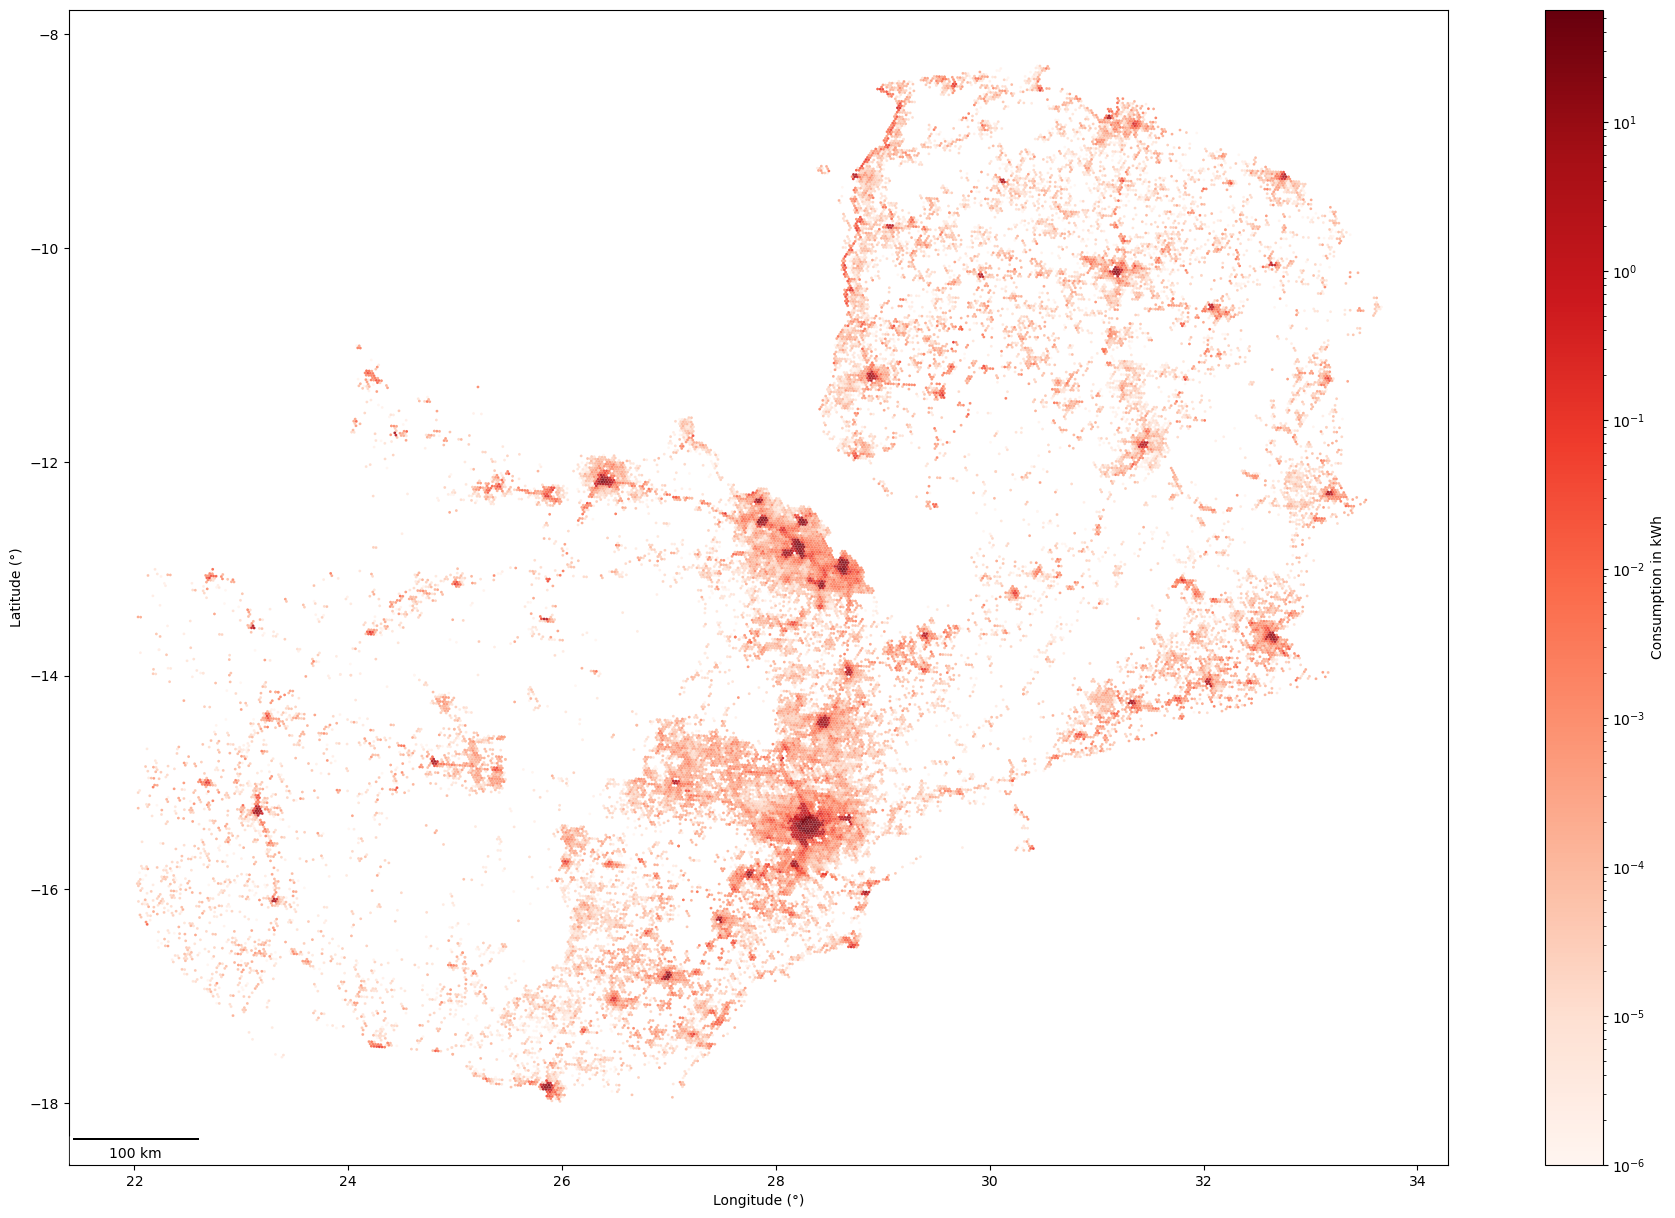

In [125]:
# Plot the demand map with a log scale value
# Create the axis first
# sns.set_theme('poster')
# sns.set_style('white')
fig, ax = plt.subplots(figsize=(25, 15))

# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

# Plot data
grid.sort_values(resultRes, ascending=True).plot(
    ax=ax, column=resultRes, cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1e-6, vmax=grid[resultRes].max()),
    legend_kwds={"label": "Consumption in kWh"}) #, "orientation": "horizontal"})

# admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
# region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
# transmission lines
# lines_gdf.plot(ax=ax, edgecolor='purple', color='purple', alpha=0.4)
# MV_lines_gdf.plot(ax=ax, edgecolor='purple', color='purple', alpha=0.05)

ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity consumption in the residential sector in {} (kWh)'.format(area) )
# txt = ax.set_title('Electricity consumption in the residential sector (kWh)' )

# print(grid.crs)

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# assert grid.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None
)

ax.add_artist(scalebar)

# Save plot as figure 
plt.savefig(out_path +'/map_res_log.png', bbox_inches='tight')

# Services

## Energy consumption based on number of buildings with access

In [126]:
# services building in each location
grid['serBui'] = grid['buildingssum'] - grid['res_Bui']
totalSerBui = grid['serBui'].sum()
totalSerBui
print(f"{totalSerBui:,.0f}", "services buildings")

6,336,017 services buildings


In [127]:
# energy consumption per building in services
grid['serBUi_Acc'] = grid['serBui'] * grid[probElec] #* (grid["Status_electrified"]=='elec')
totalSerBui_withAccess = grid['serBUi_Acc'].sum()
print("total services buildings with access:", f"{totalSerBui_withAccess:,.0f}")
ser_enBui = total_servicesenergy_GWh / totalSerBui_withAccess 
ser_enBui = ser_enBui *10**6 #conversion in kWh
print(f"{ser_enBui:,.0f}", "kWh per building")

total services buildings with access: 2,331,573
310 kWh per building


In [128]:
# compute services energy demand
grid['SEn_kWh_bui'] = ser_enBui * grid['serBUi_Acc']

## Energy consumption based on GDP

In [129]:
# energy consumption per unit of GDP (2011 international US dollars) in services
totalGDP = grid['GDP_PPP'].sum()
totalGDP = totalGDP /10**3 #conversion in k$
print("total GDP (k$):", f"{totalGDP:,.0f}")
ser_enGDP = total_servicesenergy_GWh / totalGDP 
ser_enGDP = ser_enGDP *10**6 #conversion in kWh
print(f"{ser_enGDP:,.0f}", "kWh per unit of GDP (k$)")

total GDP (k$): 29,961,050
24 kWh per unit of GDP (k$)


In [130]:
# compute services energy demand
grid['SEn_kWh_GDP'] = ser_enGDP * grid['GDP_PPP']

## Energy consumption based on employees

In [131]:
# retrieve the file and parameters
data_path = 'Residential/Data/DHSSurvey/'
file_data_employee_women = 'employee_survey_women.csv'
file_data_employee_men = 'employee_survey_men.csv'
data_employee_women = pd.read_csv(data_path + file_data_employee_women, index_col= (0,1))
data_employee_men = pd.read_csv(data_path + file_data_employee_men, index_col=(0,1))
file_data_workingpop_share = 'pop15-49_share.csv'
data_workingpop_share = pd.read_csv(data_path + file_data_workingpop_share, index_col=(1,0))
data_workingpop_share.head(4)
data_employee_women.head(4)

agricultural - self employed  clerical  \
v024       v025                                            
central    rural                         34.54      0.06   
           urban                          0.72      1.06   
copperbelt rural                         24.03      0.00   
           urban                          2.20      0.65   

                  household and domestic  not working  \
v024       v025                                         
central    rural                    1.77        46.06   
           urban                    4.93        53.55   
copperbelt rural                    2.18        49.64   
           urban                    6.10        55.97   

                  professional/technical/managerial  sales  services  \
v024       v025                                                        
central    rural                               2.55   8.39      0.56   
           urban                               6.88  24.19      4.39   
copperbelt rural                               2.05  13.59      1.27   
           urban                               6.30  17.63      4.63   

                  skilled manual  unskilled manual  
v024       v025                                     
central    rural            0.20              5.87  
           urban            0.76              3.51  
copperbelt rural            0.59              6.65  
           urban            1.67              4.86

In [132]:
# Sum all employees shares
data_employee_women['total_employee_share_women'] = data_employee_women['professional/technical/managerial'] + data_employee_women['clerical'] + data_employee_women['sales'] + data_employee_women['services'] + data_employee_women['skilled manual'] 
data_employee_men['total_employee_share_men'] = data_employee_men['professional/technical/managerial'] + data_employee_men['clerical'] + data_employee_men['sales'] + data_employee_men['services'] + data_employee_men['skilled manual'] 
data_employee_women['total_employee_share_women'].head(4)

v024        v025 
central     rural   11.76
            urban   37.28
copperbelt  rural   17.50
            urban   30.88
Name: total_employee_share_women, dtype: float64

In [133]:
# df_censusdata = df_censusdata.set_index('Region')
# df_censusdata

In [134]:
# in each cell determine the share of 15-49 women and men pop : nb of women = HH * HH size * % women * share of 15-49 women
# get_size_HH = lambda row: df_censusdata.loc[row['NAME_1'], 'size_HH_' + row['location']]
grid['nb_women'] = (
    grid['HH_total'] *
    grid.apply(get_size_HH, axis=1) *
    grid['NAME_1'].map(df_censusdata['Share women']) *
    grid['location'].map(data_workingpop_share.loc['Female']['15-49'])/100
)
total_women = grid['nb_women'].sum()
print(f"Total number of women: {total_women:,.0f}")

grid['nb_men'] = (
    grid['HH_total'] *
    grid.apply(get_size_HH, axis=1) *
    (1 - grid['NAME_1'].map(df_censusdata['Share women'])) *
    grid['location'].map(data_workingpop_share.loc['Male']['15-49'])/100
)
total_men = grid['nb_men'].sum()
print(f"Total number of men: {total_men:,.0f}")

Total number of women: 4,031,839
Total number of men: 3,634,750


In [135]:
# assess the number of employees in each cell
def calculate_working_women(row):
  # Extract location (urban or rural) and region from the current row
  location = row['location']
  region = row['NAME_1'].lower().replace('-',' ')
  # Get the corresponding percentage for the relevant category
  percent_working = data_employee_women.loc[(region, location), 'total_employee_share_women'] / 100
  return row['nb_women'] * percent_working

# Apply the function to each row in the 'grid' DataFrame
grid['nb_women_working'] = grid.apply(calculate_working_women, axis=1)

print('nb of working women',f"{grid['nb_women_working'].sum():,.0f}")

def calculate_working_men(row):
  # Extract location (urban or rural) and region from the current row
  location = row['location']
  region = row['NAME_1'].lower().replace('-',' ')
  # Get the corresponding percentage for the relevant category 
  percent_working = data_employee_men.loc[(region, location), 'total_employee_share_men'] / 100
  return row['nb_men'] * percent_working
    
# Apply the function to each row in the 'grid' DataFrame
grid['nb_men_working'] = grid.apply(calculate_working_men, axis=1)

grid['total_employee'] = grid['nb_men_working'] + grid['nb_women_working']
grid['total_employee_withaccess'] = (grid["Status_electrified"]=='elec')*grid['total_employee']
print('nb of total employee', f"{grid['total_employee'].sum():,.0f}")
print('nb of total employee with access', f"{grid['total_employee_withaccess'].sum():,.0f}")

nb of working women 946,477
nb of total employee 2,657,997
nb of total employee with access 2,239,166


In [136]:
# compute energy consumption per employee
total_employee_national = grid['total_employee'].sum()
total_employee_national_withaccess = grid['total_employee_withaccess'].sum()

ser_enEmployee = total_servicesenergy_GWh / total_employee_national_withaccess 
ser_enEmployee = ser_enEmployee *10**6 #conversion in kWh
print(f"{ser_enEmployee:,.0f}", "kWh per employee")

322 kWh per employee


In [137]:
# compute services energy demand
grid['SEn_kWh_Emp'] = ser_enEmployee * grid['total_employee']

## Weighted average of the three assessements

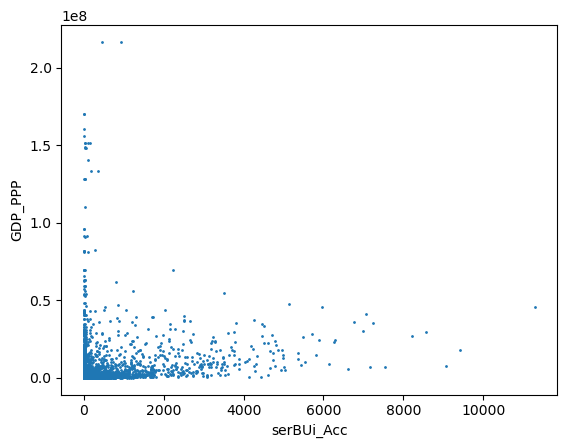

In [138]:
# Link between buildings and GDP
plt.scatter(grid['serBUi_Acc'], grid['GDP_PPP'],s=1)

# Add labels to the plot
plt.xlabel('serBUi_Acc')
plt.ylabel('GDP_PPP')

# Set the axis to logarithmic scale
# plt.yscale('log')
# plt.xscale('log')

# Show the plot
plt.show()

In [139]:
threshold_access = 0.1 # lower value than residential because easier to connect services buildings
alpha = 0
beta = 0
gama =1

In [140]:
# compute weighted average
# Create a boolean Series indicating if probElec meets the condition
# condition_met = grid[probElec] >= threshold_access
# Assign the weighted average based on the condition
grid['SEn_kWh_weighted'] = (alpha * grid['SEn_kWh_GDP'] + beta * grid['SEn_kWh_bui'] + gama * grid['SEn_kWh_Emp'] )

totalSEn_kWh_weighted = grid['SEn_kWh_weighted'].sum()
grid['SEn_kWh_final'] = grid['SEn_kWh_weighted'] / totalSEn_kWh_weighted * total_servicesenergy_GWh *10**6 

## Results per region and map

In [141]:
services_result = pd.DataFrame()
services_result = grid.groupby('NAME_1')['SEn_kWh_final'].sum() / 10**6 # conversion in GWh
pd.options.display.float_format = '{:.2f}'.format
services_result

NAME_1
Central          57.16
Copperbelt      187.19
Eastern          42.98
Luapula          25.45
Lusaka          221.42
Muchinga         12.67
North-Western    46.11
Northern         27.08
Southern         72.82
Western          28.77
Name: SEn_kWh_final, dtype: float64

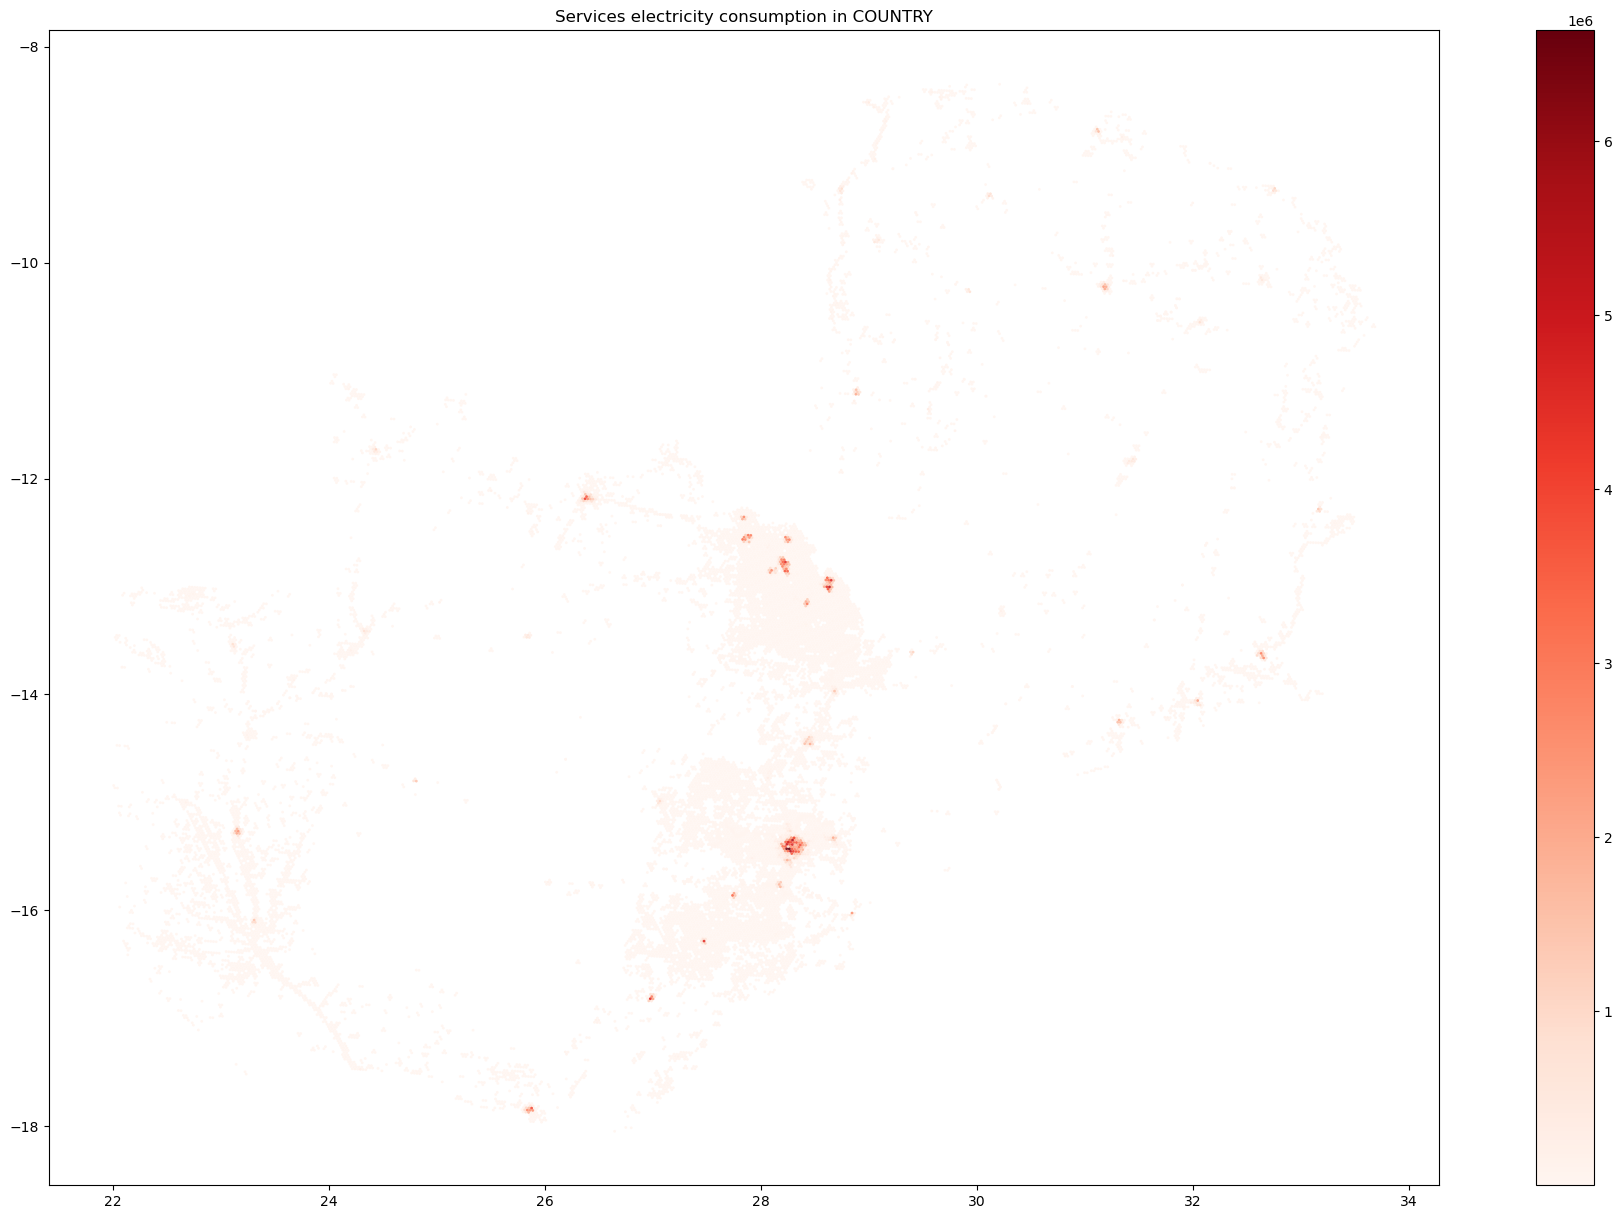

In [142]:
# Plot the energy consumption in services buildings map
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data
grid.sort_values('SEn_kWh_final', ascending=True).plot(
    ax=ax, column='SEn_kWh_final', cmap="Reds", legend=True, alpha=0.9)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Services electricity consumption in {}'.format(area) )

# Save plot as figure 
plt.savefig(out_path + '/services_map' +str(alpha) +str(gama)+'.png', bbox_inches='tight')

In [143]:
grid.to_csv(out_path + "\\" + "dataser.csv")
grid.to_file(out_path + "\\" + 'ser_energy_map.shp', index=False)
grid.to_file(out_path + "\\" + f'ser_energy_map.geojson', driver='GeoJSON', index=False)  
grid.head(3)

,h3_index,n0,n1,n2,n3,n4,n5,index,index_righ,NAME_1,...,SEn_kWh_GDP,nb_women,nb_men,nb_women_working,nb_men_working,total_employee,total_employee_withaccess,SEn_kWh_Emp,SEn_kWh_weighted,SEn_kWh_final
0,8796ac719ffffff,111238,92976,57699,17950,39034,30112,0,7,Northern,...,NaN,84.70,78.00,11.31,13.81,25.12,0.00,8096.39,NaN,NaN
1,879666d01ffffff,84135,30262,23339,78779,27081,87581,1,9,Western,...,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN
2,879614544ffffff,51580,116954,62120,62784,20898,27553,2,2,Eastern,...,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN


In [144]:
total_servicesenergy_scaled = grid.groupby('NAME_1')['SEn_kWh_final'].sum() 
print ("Services electricity consumption assessed after scaling:")
for region in regions:
    total_servicesenergy_scaled[region] = total_servicesenergy_scaled[region]/10**6  # conversion in GWh
    print (region, f"{total_servicesenergy_scaled[region]:,.1f}", "GWh" )
print (total_servicesenergy_scaled )
print (total_servicesenergy_scaled.sum() )

Services electricity consumption assessed after scaling:
Copperbelt 187.2 GWh
Muchinga 12.7 GWh
North-Western 46.1 GWh
Western 28.8 GWh
Luapula 25.4 GWh
Northern 27.1 GWh
Central 57.2 GWh
Southern 72.8 GWh
Eastern 43.0 GWh
Lusaka 221.4 GWh
NAME_1
Central          57.16
Copperbelt      187.19
Eastern          42.98
Luapula          25.45
Lusaka          221.42
Muchinga         12.67
North-Western    46.11
Northern         27.08
Southern         72.82
Western          28.77
Name: SEn_kWh_final, dtype: float64
721.6666666666666


In [145]:
total_servicesenergy_scaled

NAME_1
Central          57.16
Copperbelt      187.19
Eastern          42.98
Luapula          25.45
Lusaka          221.42
Muchinga         12.67
North-Western    46.11
Northern         27.08
Southern         72.82
Western          28.77
Name: SEn_kWh_final, dtype: float64

# Buildings

In [146]:
# total_Buienergy_scaled = total_servicesenergy_scaled + total_residentialenergy_scaled
total_Buienergy_scaled = total_servicesenergy_scaled + result_afterscaling['meth2']
print ("Services electricity consumption assessed after scaling:")
for region in regions:
    print (region, f"{total_Buienergy_scaled[region]:,.1f}", "GWh" )
print (total_Buienergy_scaled)

Services electricity consumption assessed after scaling:
Copperbelt 1,444.2 GWh
Muchinga 58.1 GWh
North-Western 232.9 GWh
Western 122.0 GWh
Luapula 94.2 GWh
Northern 156.3 GWh
Central 293.5 GWh
Southern 366.0 GWh
Eastern 199.3 GWh
Lusaka 1,777.6 GWh
NAME_1
Central          293.55
Copperbelt      1444.19
Eastern          199.33
Luapula           94.16
Lusaka          1777.61
Muchinga          58.12
North-Western    232.92
Northern         156.31
Southern         366.00
Western          121.97
dtype: float64
